In [1]:
# %load init.ipy
import os, sys, logging, datetime
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from nose import tools

import corner
import tqdm.notebook as tqdm
import memory_profiler as mpro

import kalepy as kale
from kalepy.utils import nbshow

# NOTE: This is for when the notebook is converted to a python script
def get_ipython():
    return type('Dummy', (object,), dict(run_line_magic=lambda *args, **kwargs: None))

%reload_ext autoreload
%autoreload 2


# Utilities

## bound_indices()

In [2]:
def the_func(func, shp=(3, 1000)):
    data = np.random.uniform(-1.0, 1.0, shp)
    ndim = shp[0]
    bnds = np.sort(np.random.uniform(-1.0, 1.0, (ndim, 2)), axis=-1)
    idx = func(data, bnds)
    return

In [3]:
%timeit the_func(kale.utils.bound_indices, shp=(1, 1000))

In [4]:
%timeit the_func(kale.utils._bound_indices, shp=(1, 1000))

# Resampling

In [5]:
data_shape = (7, 607)
# num_samples = 3.5e6
num_trials = 7

num_samples = np.logspace(0, 6, 15)

data = np.random.lognormal(size=data_shape)
reflect = [[0.0, None] for ii in range(data_shape[0])]

weights = np.random.uniform(size=data_shape[1])


kde = kale.KDE(data, weights=weights, diagonal=True, bw_rescale=0.2)
durs = np.zeros((num_samples.size, num_trials))
mems = np.zeros_like(durs)

for ii, num in enumerate(tqdm.tqdm(num_samples)):
    for jj in range(num_trials):
        beg = datetime.datetime.now()
        def func():
            kde.resample(int(num), reflect=reflect)
            return
        
        mem_usage = mpro.memory_usage(func)
        temp = datetime.datetime.now() - beg
        temp = temp.total_seconds()
        durs[ii, jj] = temp        
        mems[ii, jj] = np.max(mem_usage)
        

In [6]:
data_shape = (7, 607)
# num_samples = 3.5e6
num_trials = 7

num_samples = np.logspace(0, 6, 15)
# num_samples = np.array([1.00000000e+00, 2.68269580e+00, 7.19685673e+00, 1.93069773e+01,
#        5.17947468e+01, 1.38949549e+02, 3.72759372e+02, 1.00000000e+03,
#        2.68269580e+03, 7.19685673e+03, 1.93069773e+04, 5.17947468e+04,
#        1.38949549e+05])

data = np.random.lognormal(size=data_shape)

reflect = [[0.0, None] for ii in range(data_shape[0])]

weights = np.random.uniform(size=data_shape[1])


kde = kale.KDE(data, weights=weights, diagonal=True, bw_rescale=0.2)
durs_chunk = np.zeros((num_samples.size, num_trials))
mems_chunk = np.zeros_like(durs_chunk)

for ii, num in enumerate(tqdm.tqdm(num_samples)):
    for jj in range(num_trials):
        beg = datetime.datetime.now()
        def func():
            kde.resample(int(num), reflect=reflect)
            return
        
        mem_usage = mpro.memory_usage(func)
        temp = datetime.datetime.now() - beg
        temp = temp.total_seconds()
        durs_chunk[ii, jj] = temp        
        mems_chunk[ii, jj] = np.max(mem_usage)
        
    print("{:2d}: {:.2e} ==> t = {:.2e} [s], m = {:.2e} [MB]".format(
        ii, num, np.mean(durs_chunk[ii]), np.mean(mems_chunk[ii])))

 0: 1.00e+00 ==> t = 8.09e-02 [s], m = 1.29e+02 [MB]
 1: 2.68e+00 ==> t = 7.13e-02 [s], m = 1.29e+02 [MB]
 2: 7.20e+00 ==> t = 9.10e-02 [s], m = 1.20e+02 [MB]
 3: 1.93e+01 ==> t = 8.87e-02 [s], m = 1.19e+02 [MB]
 4: 5.18e+01 ==> t = 8.58e-02 [s], m = 1.20e+02 [MB]
 5: 1.39e+02 ==> t = 1.00e-01 [s], m = 1.22e+02 [MB]
 6: 3.73e+02 ==> t = 1.05e-01 [s], m = 1.28e+02 [MB]
 7: 1.00e+03 ==> t = 1.92e-01 [s], m = 1.38e+02 [MB]
 8: 2.68e+03 ==> t = 2.54e-01 [s], m = 1.38e+02 [MB]
 9: 7.20e+03 ==> t = 2.54e-01 [s], m = 1.38e+02 [MB]
10: 1.93e+04 ==> t = 2.47e-01 [s], m = 1.40e+02 [MB]
11: 5.18e+04 ==> t = 3.06e-01 [s], m = 1.51e+02 [MB]
12: 1.39e+05 ==> t = 4.84e-01 [s], m = 1.54e+02 [MB]
13: 3.73e+05 ==> t = 1.02e+00 [s], m = 1.68e+02 [MB]
14: 1.00e+06 ==> t = 2.78e+00 [s], m = 1.99e+02 [MB]



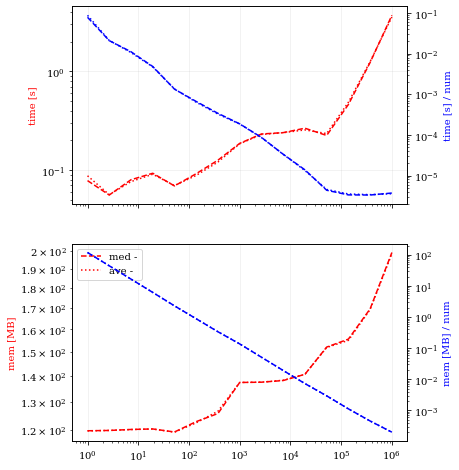

In [7]:
fig, axes = plt.subplots(figsize=[6, 8], nrows=2, sharex=True)
for ax in axes:
    ax.set(xscale='log', yscale='log')
    ax.grid(alpha=0.2)

xx = num_samples
values = [durs, mems]
value_names = ['time [s]', 'mem [MB]']
funcs = [np.median, np.mean]
func_names = ['med', 'ave']
lines = ['--', ':']

norms = [1.0, num_samples]
colors = ['r', 'b']
norm_names = ['-', 'N']

for ii, (ax, vals, vname) in enumerate(zip(axes, values, value_names)):
    ax.set_ylabel(vname, color=colors[0])
    tw = ax.twinx()
    tw.set_yscale('log')
    tw.set_ylabel(vname + ' / num', color=colors[1])
    
    use_axes = [ax, tw]
    for jj, (func, fname, ls) in enumerate(zip(funcs, func_names, lines)):
        
        for kk, (norm, nname, cc, art) in enumerate(zip(norms, norm_names, colors, use_axes)):
            norm = np.atleast_2d(norm).T
            yy = func(vals/norm, axis=-1)
            name = fname + ' ' + nname
            art.plot(xx, yy, color=cc, ls=ls, label=name)

axes[1].legend()
nbshow()

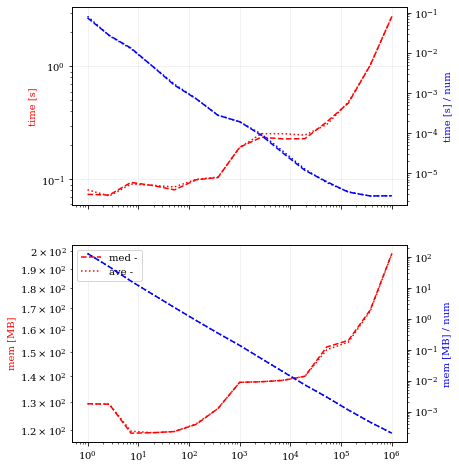

In [8]:
fig, axes = plt.subplots(figsize=[6, 8], nrows=2, sharex=True)
for ax in axes:
    ax.set(xscale='log', yscale='log')
    ax.grid(alpha=0.2)

xx = num_samples
values = [durs_chunk, mems_chunk]

value_names = ['time [s]', 'mem [MB]']
funcs = [np.median, np.mean]
func_names = ['med', 'ave']
lines = ['--', ':']

norms = [1.0, num_samples]
colors = ['r', 'b']
norm_names = ['-', 'N']

for ii, (ax, vals, vname) in enumerate(zip(axes, values, value_names)):
    ax.set_ylabel(vname, color=colors[0])
    tw = ax.twinx()
    tw.set_yscale('log')
    tw.set_ylabel(vname + ' / num', color=colors[1])
    
    use_axes = [ax, tw]
    for jj, (func, fname, ls) in enumerate(zip(funcs, func_names, lines)):
        
        for kk, (norm, nname, cc, art) in enumerate(zip(norms, norm_names, colors, use_axes)):
            norm = np.atleast_2d(norm).T
            yy = func(vals/norm, axis=-1)
            name = fname + ' ' + nname
            art.plot(xx, yy, color=cc, ls=ls, label=name)

axes[1].legend()
nbshow()

### Vary Chunk Sizes

This is very slow, so currently commented out.

In [9]:
# data_shape = (7, 607)
# # num_samples = 1e6
# num_samples = 1e5
# num_trials = 5

# chunk_sizes = np.logspace(4, 6, 9)

# data = np.random.lognormal(size=data_shape)

# reflect = [[0.0, None] for ii in range(data_shape[0])]

# weights = np.random.uniform(size=data_shape[1])

# chunk_durs = np.zeros((chunk_sizes.size, num_trials))
# chunk_mems = np.zeros_like(chunk_durs)

# for ii, chunk in enumerate(chunk_sizes):

#     kde = kale.KDE(data, weights=weights, diagonal=True, bw_rescale=0.2, chunk=chunk)
#     for jj in range(num_trials):
#         beg = datetime.datetime.now()
#         def func():
#             kde.resample(int(num_samples), reflect=reflect)
#             return

#         mem_usage = mpro.memory_usage(func)
#         temp = datetime.datetime.now() - beg
#         temp = temp.total_seconds()
#         chunk_durs[ii, jj] = temp        
#         chunk_mems[ii, jj] = np.max(mem_usage)

#     print("{:2d}: {:.2e} ==> t = {:.2e} [s], m = {:.2e} [MB]".format(
#         ii, chunk, np.mean(chunk_durs[ii]), np.mean(chunk_mems[ii])))

In [10]:
# fig, axes = plt.subplots(figsize=[6, 8], nrows=2, sharex=True)
# for ax in axes:
#     ax.set(xscale='log', yscale='log')
#     ax.grid(alpha=0.2)

# xx = chunk_sizes
# values = [chunk_durs, chunk_mems]

# value_names = ['time [s]', 'mem [MB]']
# funcs = [np.median, np.mean]
# func_names = ['med', 'ave']
# lines = ['--', ':']

# norms = [1.0, num_samples]
# colors = ['r', 'b']
# norm_names = ['-', 'N']

# for ii, (ax, vals, vname) in enumerate(zip(axes, values, value_names)):
#     ax.set_ylabel(vname, color=colors[0])
#     tw = ax.twinx()
#     tw.set_yscale('log')
#     tw.set_ylabel(vname + ' / num', color=colors[1])
    
#     use_axes = [ax, tw]
#     for jj, (func, fname, ls) in enumerate(zip(funcs, func_names, lines)):
        
#         for kk, (norm, nname, cc, art) in enumerate(zip(norms, norm_names, colors, use_axes)):
#             norm = np.atleast_2d(norm).T
#             yy = func(vals/norm, axis=-1)
#             name = fname + ' ' + nname
#             art.plot(xx, yy, color=cc, ls=ls, label=name)

# axes[1].legend()
# nbshow()